# Predicting the functional status of public water pumps in Tanzania

In [1]:
# to print all outputs in a cell instead of just the last one 
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = 'all'  # 'last_expr' to revert to default behaviour 

# import
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
#set figure size
plt.rcParams['figure.figsize'] = 9, 6
import seaborn as sns
sns.set_style('whitegrid')   

# to build specific estimators
from sklearn.base import BaseEstimator, TransformerMixin

#from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
#from sklearn.tree import DecisionTreeClassifier 
#from sklearn.metrics import f1_score

# to display all columns of dataframe 
pd.set_option('display.max_columns', 50)

In [2]:
# read data files
train_predictors = pd.read_csv('./input/training_X.csv')
train_target = pd.read_csv('./input/training_y.csv')
# create dataset with both label and independent variables
train_set = pd.concat([train_target[['status_group']], train_predictors], axis=1, sort=False)

## EDA
59400 observations x  40 features

In [3]:
print('Dimensions of training set = {:d} observations x  {:d} features'.format(train_predictors.shape[0], train_predictors.shape[1]))
train_set.sample(3)

Dimensions of training set = 59400 observations x  40 features


,status_group,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
32092,non functional,3065,0.0,2012-10-18,Government Of Tanzania,0,DWE,33.547272,-4.618665,Bwawani,0,Internal,Bwawani,Tabora,14,2,Igunga,Simbo,0,True,GeoData Consultants Ltd,Water authority,NaN,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe multiple,communal standpipe
51843,non functional,7911,0.0,2012-10-23,Mileniam Project,0,Mileniam project,32.644339,-5.152943,Simba Ismail,0,Lake Tanganyika,Isenga Kati,Tabora,14,3,Uyui,Ilolangulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump
44403,non functional,57329,0.0,2011-03-05,Government Of Tanzania,408,DWE,38.414986,-4.372967,Tenkini,0,Pangani,Tenki,Tanga,4,1,Lushoto,Lunguza,1,True,GeoData Consultants Ltd,VWC,Kinyang`a streem,True,1976,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


### Target

In [4]:
train_set['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

### Independant variables

In [5]:
summary = pd.DataFrame(np.array([train_predictors.dtypes, 
                                 train_predictors.isnull().sum(), 
                                 train_predictors.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                                 
                       columns=np.array(list(train_predictors)))
display(summary)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
Dtype,int64,float64,object,object,int64,object,float64,float64,object,int64,object,object,object,int64,int64,object,object,int64,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
NbrNullValues,0,0,0,3635,0,3655,0,0,0,0,0,371,0,0,0,0,0,0,3334,0,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NbrDistinctVal,59400,98,356,1897,2428,2145,57516,57517,37400,65,9,19287,21,27,20,125,2092,1049,2,1,12,2696,2,55,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6


### Numerical variables

In [6]:
train_predictors.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


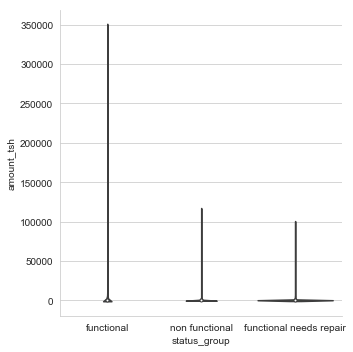

In [7]:
sns.catplot(x='status_group', y='amount_tsh', data=train_set, kind='violin');
#df = train_set[['status_group', 'amount_tsh']]
#df['amount_tsh'] = df['amount_tsh'].apply(lambda x: min(x, 2000))
#sns.catplot(x='status_group', y='amount_tsh', data=df, kind='violin');

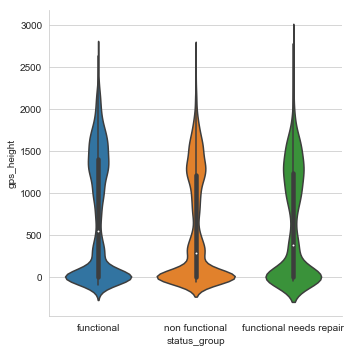

In [8]:
sns.catplot(x='status_group', y='gps_height', data=train_set, kind='violin');

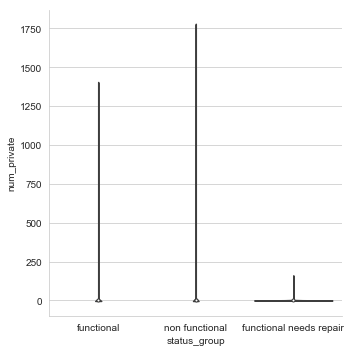

In [9]:
sns.catplot(x='status_group', y='num_private', data=train_set, kind='violin');
#df = train_set[['status_group', 'num_private']]
#df['num_private'] = df['num_private'].apply(lambda x: min(x, 5))
#sns.catplot(x='status_group', y='num_private', data=df, kind='violin');

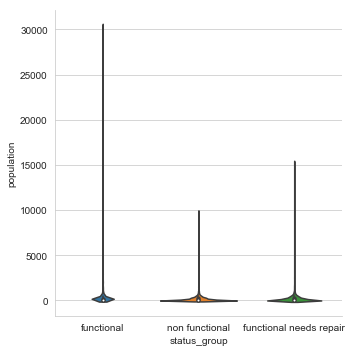

In [10]:
sns.catplot(x='status_group', y='population', data=train_set, kind='violin');

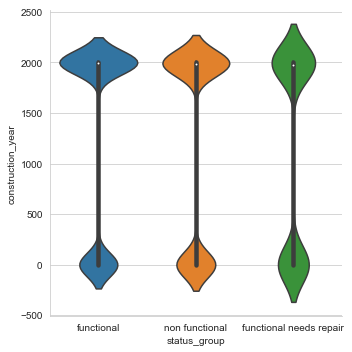

In [11]:
sns.catplot(x='status_group', y='construction_year', data=train_set, kind='violin');

## Feature Engineering

This dataset contains several categorical variables with very high cardinality, like for example *funder* with 1897 unique values. There are 3 approaches possible to handle this type of features:
* group together values that have close meaning (this is however not possible for variables like *funder* for which there is no clear proximity measure between different values)
* discard values with low frequencies (possible, but this would probably be unsufficient to reduce enough the number of unique values)
* **transform the initial feature into a continuous numerical feature**  

We will use option 3, and we define 3 functions $f_F$, $f_R$ and $f_N$:
$$f_F(x) = \frac{N_F(x) + p_F}{N(x) + 1}$$  
$$f_R(x) = \frac{N_R(x) + p_R}{N(x) + 1}$$  
$$f_N(x) = \frac{N_N(x) + p_N}{N(x) + 1}$$ 
where:
* $x$ is a given value of the high cardinality variable V, 
* $N_F(x)$, $N_R(x)$ and $f_N(x)$ are the number of observations with V=x and respectively equal to Functional, Repair, and Non Functional 
* $N(x)$ is the total number of observations with V=X, with $N(x) = N_F(x) + N_R(x) + f_N(x)$
* $p_F$, $p_R$ and $p_N$ are the frequencies over the full set of status Functional, Repair, and Non Functional  
  
Now, it is easy to see that the sum of $f_F$, $f_R$ and $f_N$ is equal to 1 and that these 3 functions can be considered as probabilities of each status: 
$$f_F(x) + f_R(x) + f_N(x) = \frac{N_F(x) + p_F + N_R(x) + p_R + N_N(x) + p_N}{N(x) + 1}
= \frac{N_F(x) + N_R(x) + N_N(x) + p_F + p_R + p_N}{N(x) + 1} = \frac{N(x) + 1}{N(x) + 1}$$  

The rationale for these functions is:
* their value gets closer to the observed frequencies $\frac{N_F(x)}{N(x)}$ as the number of observations $N(x)$ increases. Thus they are putting more weight on frequent values 
* they have an intuitive meaning as estimation of probabilities
* they are defined even if the value x is not included in the training set  

In [40]:
# define transformer to transform high cardinality variables to numerical functions

class HighCardinalityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._frequencies = {}
        self._mapper = {}
        pass
    
    def fit(self, X, y):
        # TODO check that X and y have valid format
        
        # concatenate X and y and rename columns for easier indexing
        df = pd.concat([X,y], axis=1)
        df.rename(columns={df.columns[0]: 'X', df.columns[1]: 'y'}, inplace=True)
        
        # compute frequencies
        self._default_frequencies = {}
        for status in ['functional', 'functional needs repair', 'non functional']: 
            self._frequencies[status] = np.count_nonzero(y == status) / y.shape[0]  
            
        # get all unique values in X
        predictor_values = df['X'].unique()
        
        # replace y with 3 columns 'y_functional', 'y_functional needs repair', 'y_non functional' with counts 
        df = pd.get_dummies(data=df, columns=['y'])
        df = df.groupby('X').sum()
        df['count'] = df['y_functional'] +  df['y_functional needs repair'] + df['y_non functional']
        # calculate the 3 probability estimates
        df['functional'] = (df['y_functional'] + self._frequencies['functional']) / (df['count'] + 1)
        df['functional needs repair'] = (df['y_functional needs repair'] + self._frequencies['functional needs repair']) / (df['count'] + 1)
        df['non functional'] = (df['y_non functional'] + self._frequencies['non functional']) / (df['count'] + 1) 

        # create mapper
        self._mapper = df[['functional', 'functional needs repair', 'non functional']].to_dict()
        
        return self
    
    # TODO implement transform method
    def transform(self, X, y=None):
        res = X.copy()
        
        col_name = 'lga'
        
        for y_name in ['non functional']: ## , 'functional needs repair', 'non functional']: 
            mapper = self._mapper[y_name]
            print('OK ici')
            new_col = col_name + '_f_' + y_name
            print(new_col)
            res[new_col] = X[col_name].map(mapper)
            # TODO fill NA value
        return res
#        return pd.concat([X, f], axis=1)
    
    def get_frequencies(self):        
        return self._frequencies
    
    def get_mapper(self):
        return self._mapper

hct = HighCardinalityTransformer()
hct.fit(train_predictors[['lga']], train_target[['status_group']])
res = hct.transform(train_predictors[['lga']])
display(res)
#print(hct.get_frequencies())
print(hct.get_mapper()['non functional'])

HighCardinalityTransformer()

OK ici
lga_f_non functional


,lga,lga_f_non functional
0,Ludewa,0.205990
1,Serengeti,0.370131
2,Simanjiro,0.402538
3,Nanyumbu,0.731976
4,Karagwe,0.411119
5,Mkinga,0.222783
6,Shinyanga Rural,0.416612
7,Kahama,0.442514
8,Tabora Urban,0.649899
9,Karagwe,0.411119


{'Arusha Rural': 0.26287649036252386, 'Arusha Urban': 0.2247537878787879, 'Babati': 0.1511410984848485, 'Bagamoyo': 0.26591607457338917, 'Bahi': 0.2950410774410775, 'Bariadi': 0.1599187117353501, 'Biharamulo': 0.2682778277827783, 'Bukoba Rural': 0.3409513164431197, 'Bukoba Urban': 0.36386789240721823, 'Bukombe': 0.28618299499852895, 'Bunda': 0.6819686615586388, 'Chamwino': 0.5011041448972483, 'Chato': 0.4193427950389976, 'Chunya': 0.42268977399412183, 'Dodoma Urban': 0.6528808981176669, 'Geita': 0.42000867571419714, 'Hai': 0.12361700067770356, 'Hanang': 0.3032154269972452, 'Handeni': 0.4485656565656566, 'Igunga': 0.5350567623133995, 'Ilala': 0.3100085189241816, 'Ileje': 0.30769070010449323, 'Ilemela': 0.4642254714981988, 'Iramba': 0.2942830136224632, 'Iringa Rural': 0.23509498274930374, 'Kahama': 0.4425140291806958, 'Karagwe': 0.41111948500549533, 'Karatu': 0.028697989064961543, 'Kasulu': 0.2246032847559565, 'Kibaha': 0.3051268237934905, 'Kibondo': 0.4061534199134199, 'Kigoma Rural': 0